In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Conv1D, LeakyReLU, BatchNormalization, Dropout, Attention, LayerNormalization
from tensorflow.keras import regularizers, initializers
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import load

import warnings
warnings.filterwarnings("ignore")

/Users/annapetrov/Downloads/study/диплом_мага/final_code_2/.venv311/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
stock_name = 'SBER'

In [3]:
all_stocks = pd.read_csv('/Users/annapetrov/Downloads/stock_markets_202601022018.csv')
print(all_stocks.shape)
all_stocks.head()

(2894, 8)


,date,open,close,high,low,value,volume,ticker
0,2025-01-03,280.00,272.25,280.41,271.80,1.185357e+10,43086870.0,SBER
1,2025-01-06,270.88,274.37,274.41,270.07,7.737094e+09,28454750.0,SBER
2,2025-01-08,273.07,277.00,277.87,273.07,7.356165e+09,26634660.0,SBER
3,2025-01-09,276.71,271.80,278.77,270.73,1.449133e+10,52952880.0,SBER
4,2025-01-10,272.31,278.77,279.53,270.27,1.962313e+10,71154220.0,SBER


In [4]:
stock_df = all_stocks[all_stocks['ticker'] == stock_name]
stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df['date'] = stock_df['date'].dt.date

In [5]:
twitter_df = pd.read_csv('twitter_df.csv')

In [6]:
final_df = pd.merge(
    stock_df,
    twitter_df,
    left_on="date",
    right_on="datetime",
    how='left'
)

final_df = final_df.drop(columns=['ticker', 'datetime'])
print(final_df.shape)

(290, 9)


In [7]:
final_df = final_df.drop(columns=['Unnamed: 0'])

In [ ]:
# # ПРОСТАВЛЕНИЕ sentiment_score УДАЛИТЬ ПОТОМ

# import numpy as np

# # дневная доходность
# returns = (final_df['close'] - final_df['open']) / final_df['open']

# # сигмоид + масштабирование (похоже на реальные sentiment-модели)
# sentiment = np.tanh(returns * 8)

# # небольшой шум (соцсети ≠ рынок 1 к 1)
# np.random.seed(42)
# sentiment += np.random.normal(0, 0.05, size=len(sentiment))

# # ограничим диапазон
# final_df['sentiment_score'] = sentiment.clip(-0.6, 0.6)

In [9]:
final_df.head()

,date,open,close,high,low,value,volume,sentiment_score
0,2025-01-03,280.00,272.25,280.41,271.80,1.185357e+10,43086870.0,-0.193044
1,2025-01-06,270.88,274.37,274.41,270.07,7.737094e+09,28454750.0,0.095795
2,2025-01-08,273.07,277.00,277.87,273.07,7.356165e+09,26634660.0,0.147014
3,2025-01-09,276.71,271.80,278.77,270.73,1.449133e+10,52952880.0,-0.064856
4,2025-01-10,272.31,278.77,279.53,270.27,1.962313e+10,71154220.0,0.175830


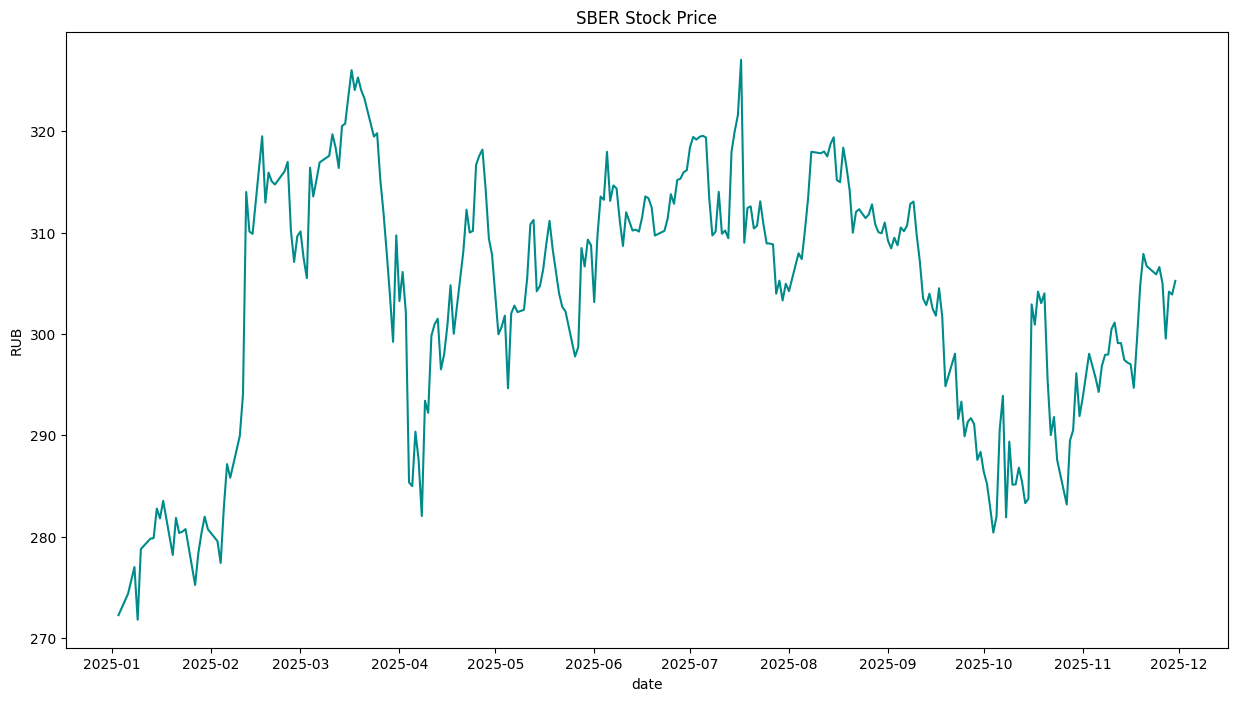

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['date'], final_df['close'], color='#008B8B')
ax.set(xlabel="date", ylabel="RUB", title=f"{stock_name} Stock Price")
plt.show()

In [ ]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,2].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,2].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,2].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    data['20SD'] = data.iloc[:, 2].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    data['EMA'] = data.iloc[:,2].ewm(com=0.5).mean()

    data['logmomentum'] = np.log(data.iloc[:,2] - 1)

    return data

In [12]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,date,open,close,high,low,value,volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2025-02-03,280.21,279.55,280.35,278.00,8.477126e+09,30373760.0,0.054442,279.561429,279.3755,-0.444687,2.928295,285.232090,273.518910,279.991292,5.629598
1,2025-02-04,279.55,277.40,281.41,275.70,6.685825e+09,23986670.0,-0.072739,279.084286,279.5270,-0.568612,2.727171,284.981343,274.072657,278.263764,5.621849
2,2025-02-05,277.30,282.88,283.89,275.34,1.203512e+10,43070410.0,0.162981,280.177143,279.8210,0.152345,2.757191,285.335383,274.306617,281.341255,5.641481
3,2025-02-06,283.89,287.15,288.92,282.09,1.988558e+10,69363150.0,0.020372,281.434286,280.5885,0.139897,2.534360,285.657220,275.519780,285.213752,5.656516
4,2025-02-07,287.66,285.81,288.90,285.08,7.924869e+09,27626070.0,-0.078623,282.212857,280.9405,-0.531894,2.748355,286.437211,275.443789,285.611251,5.651822


In [13]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['date'], dataset['close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

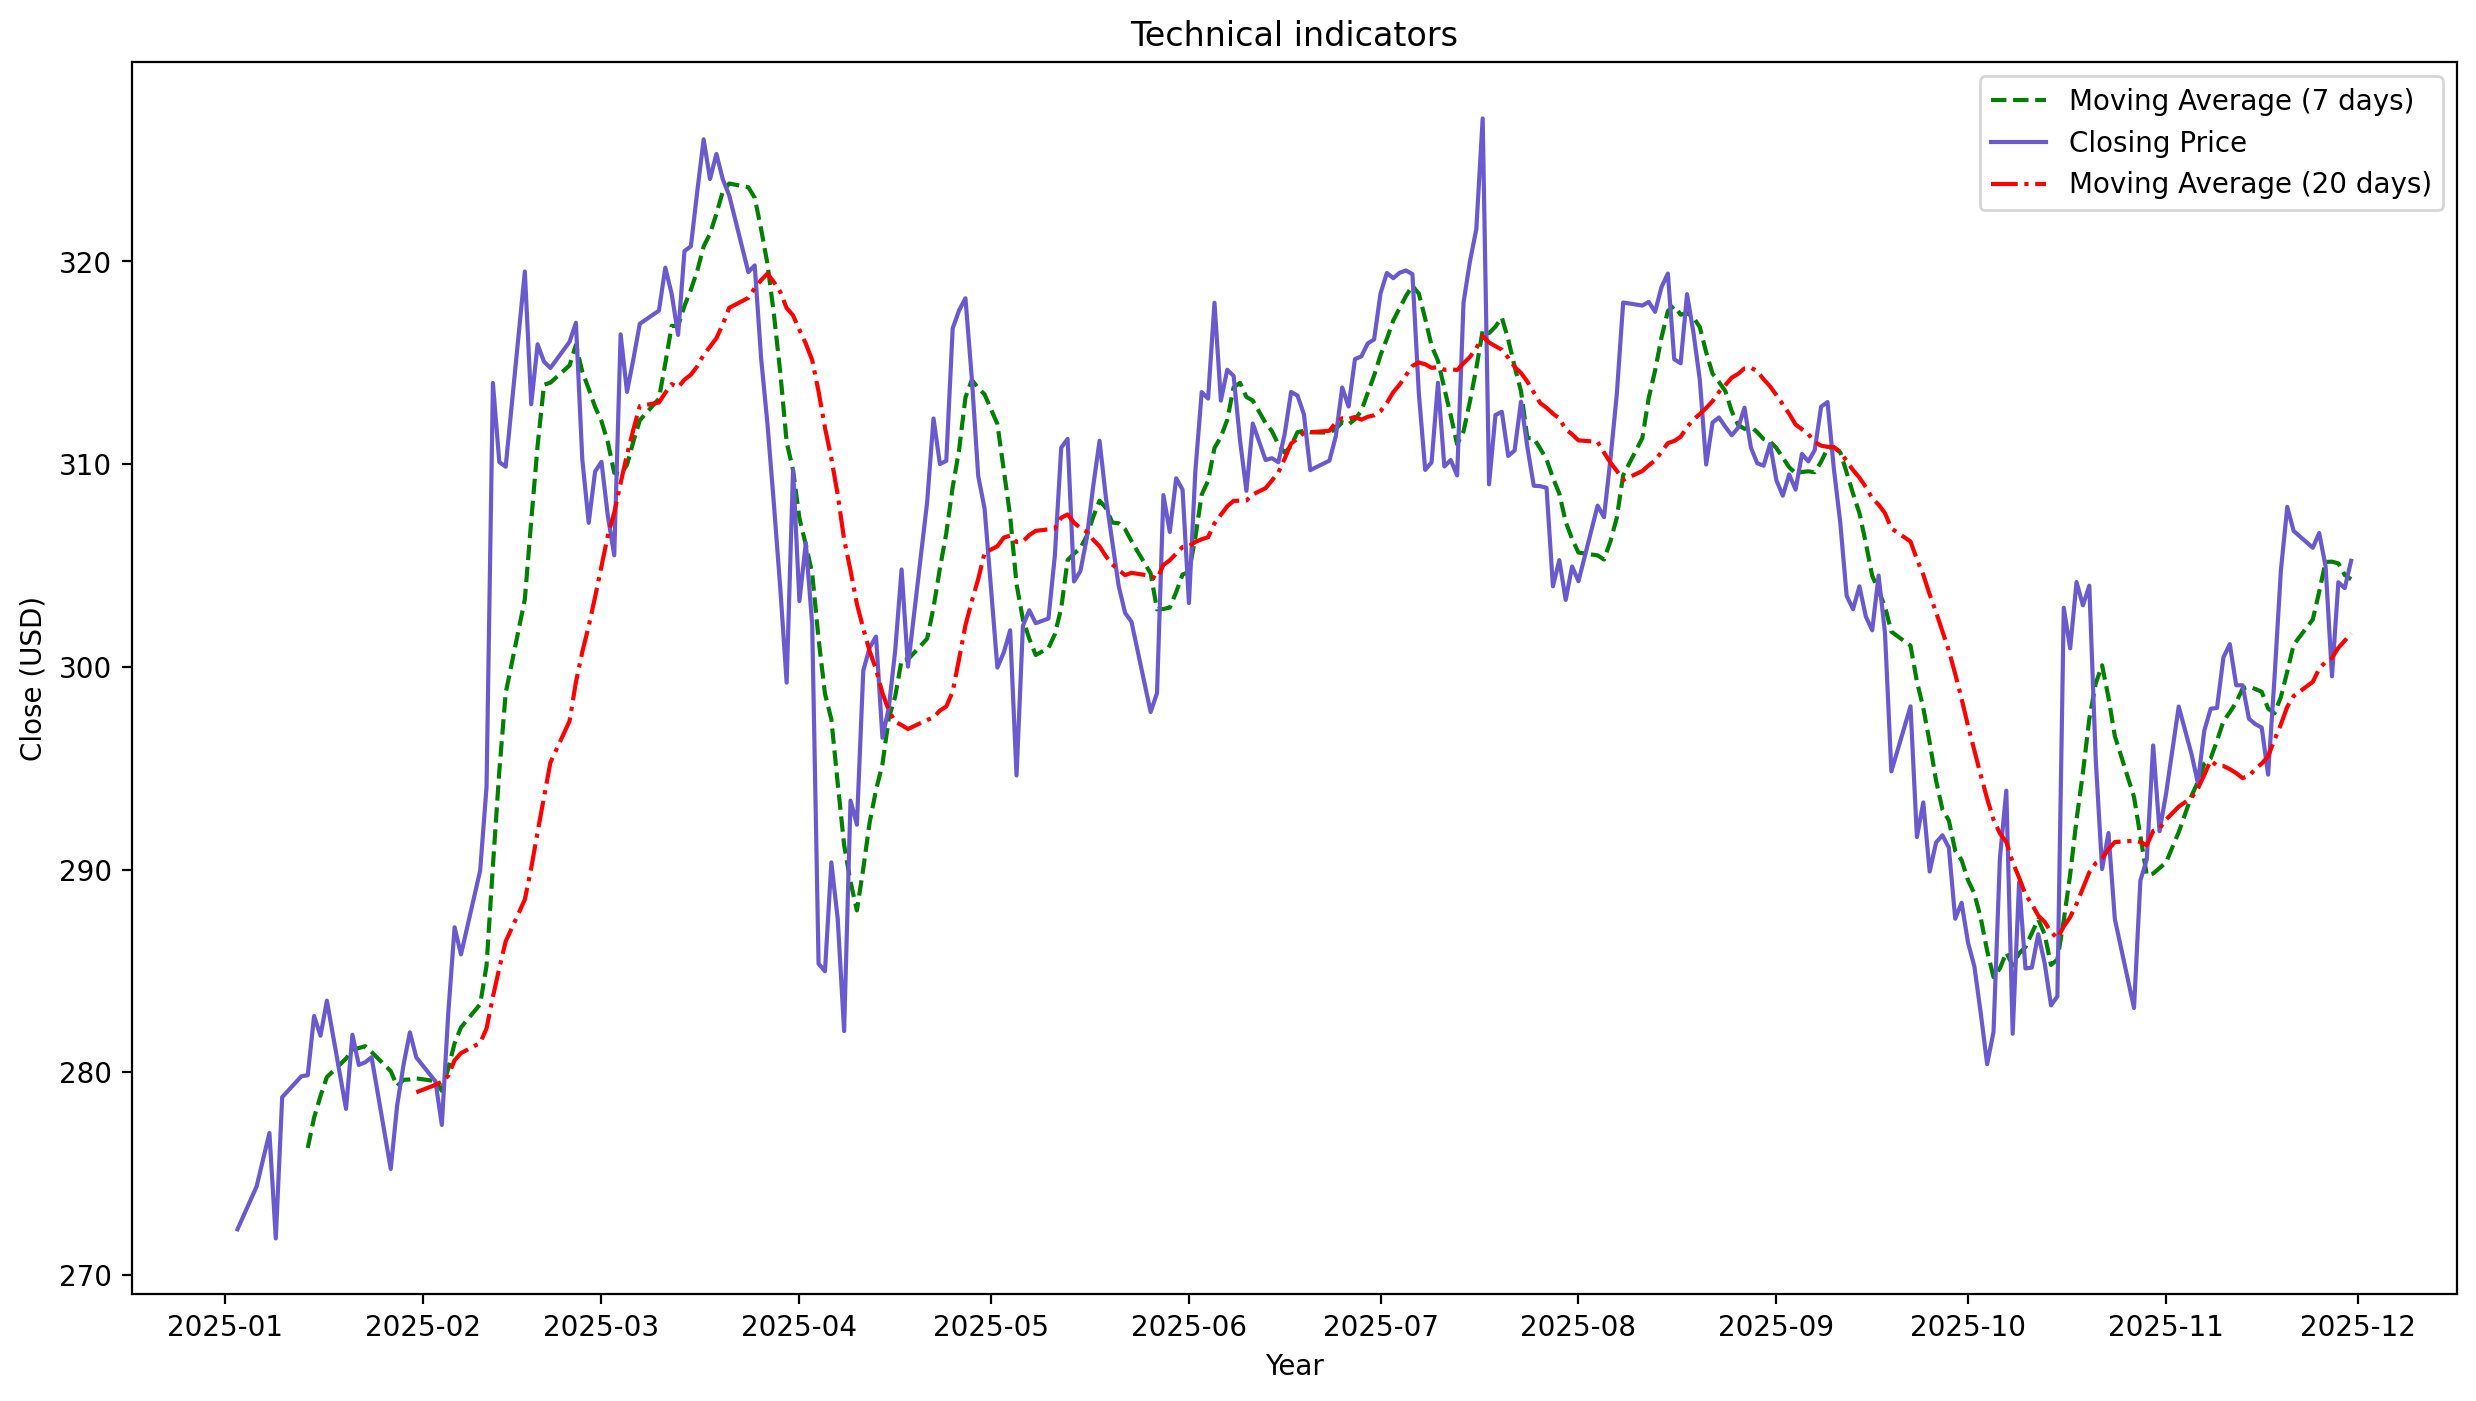

In [14]:
tech_ind(tech_df)

In [15]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [16]:
datetime_series = pd.to_datetime(dataset['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='date')
dataset = dataset.drop(columns='date')

In [ ]:
def normalize_data(df, range, target_column):
    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [18]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [19]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [21]:
dataset.head()

,open,close,high,low,value,volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
2025-02-03,280.21,279.55,280.35,278.00,8.477126e+09,30373760.0,0.054442,279.561429,279.3755,-0.444687,2.928295,285.232090,273.518910,279.991292,5.629598
2025-02-04,279.55,277.40,281.41,275.70,6.685825e+09,23986670.0,-0.072739,279.084286,279.5270,-0.568612,2.727171,284.981343,274.072657,278.263764,5.621849
2025-02-05,277.30,282.88,283.89,275.34,1.203512e+10,43070410.0,0.162981,280.177143,279.8210,0.152345,2.757191,285.335383,274.306617,281.341255,5.641481
2025-02-06,283.89,287.15,288.92,282.09,1.988558e+10,69363150.0,0.020372,281.434286,280.5885,0.139897,2.534360,285.657220,275.519780,285.213752,5.656516
2025-02-07,287.66,285.81,288.90,285.08,7.924869e+09,27626070.0,-0.078623,282.212857,280.9405,-0.531894,2.748355,286.437211,275.443789,285.611251,5.651822


In [22]:
print(dataset.columns.tolist())

['open', 'close', 'high', 'low', 'value', 'volume', 'sentiment_score', 'MA7', 'MA20', 'MACD', '20SD', 'upper_band', 'lower_band', 'EMA', 'logmomentum']


In [23]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (265, 5, 15)
y shape: (265, 1)
yc shape: (265, 5, 1)


In [24]:
X_train

array([[[-0.8809816 , -0.91339376, -1.        , ..., -0.50360969,
         -0.92602569, -0.90619362],
        [-0.90797546, -1.        , -0.95710239, ..., -0.4815832 ,
         -1.        , -1.        ],
        [-1.        , -0.77925478, -0.85673816, ..., -0.47227691,
         -0.86821905, -0.76232252],
        [-0.73047035, -0.60725076, -0.65317685, ..., -0.42402071,
         -0.70239522, -0.58030617],
        [-0.57627812, -0.6612286 , -0.65398624, ..., -0.42704339,
         -0.68537396, -0.63713197]],

       [[-0.90797546, -1.        , -0.95710239, ..., -0.4815832 ,
         -1.        , -1.        ],
        [-1.        , -0.77925478, -0.85673816, ..., -0.47227691,
         -0.86821905, -0.76232252],
        [-0.73047035, -0.60725076, -0.65317685, ..., -0.42402071,
         -0.70239522, -0.58030617],
        [-0.57627812, -0.6612286 , -0.65398624, ..., -0.42704339,
         -0.68537396, -0.63713197],
        [-0.57832311, -0.49486405, -0.42533387, ..., -0.45774599,
         -0.56

In [25]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

In [83]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([
        LSTM(1024, return_sequences=True, input_shape=(input_dim, feature_size), recurrent_dropout=0.3),
        LSTM(512, return_sequences=True, recurrent_dropout=0.3),
        LSTM(256, return_sequences=True, recurrent_dropout=0.3),
        LSTM(128, return_sequences=True, recurrent_dropout=0.3),
        LSTM(64, recurrent_dropout=0.3),
        Dense(32),
        Dense(16),
        Dense(8),
        Dense(output_dim)
    ])
    return model

In [84]:
def make_discriminator_model(input_dim):
    model = tf.keras.Sequential([
        Conv1D(8, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(0.01), input_shape=(input_dim+1,1)),
        Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(0.01)),
        Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(0.01)),
        Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(0.01)),
        Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(0.01)),
        LeakyReLU(),
        Dense(220, use_bias=False),
        LeakyReLU(),
        Dense(220, use_bias=False, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

In [85]:
def discriminator_loss(real_output, fake_output):
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_fn(tf.ones_like(real_output), real_output)
    fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return loss_fn(tf.ones_like(fake_output), fake_output)

In [ ]:
@tf.function
def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    yc = tf.cast(yc, tf.float32)
    real_y = tf.cast(real_y, tf.float32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_exp = tf.expand_dims(generated_data, axis=1)
        
        d_fake_input = tf.concat([generated_data_exp, yc], axis=1)
        real_y_exp = tf.expand_dims(real_y, axis=1)
        d_real_input = tf.concat([real_y_exp, yc], axis=1)

        fake_output = discriminator(d_fake_input, training=True)
        real_output = discriminator(d_real_input, training=True)

        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}

In [87]:
def train(real_x, real_y, yc, epochs, generator, discriminator, g_optimizer, d_optimizer, stock_name="default_stock", checkpoint=100):
    D_losses, G_losses = [], []
    Predicted_price, Real_price = [], []

    for epoch in tqdm(range(epochs), desc="Training GAN"):
        real_batch, fake_batch, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)

        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())

        Predicted_price.append(fake_batch.numpy())
        Real_price.append(real_batch.numpy())

        if (epoch+1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_{epoch}.h5')
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_{epoch}.h5')
            print(f"Epoch {epoch+1}: D_loss={loss['d_loss'].numpy():.5f}, G_loss={loss['g_loss'].numpy():.5f}")

    # Преобразуем предсказания и реальные цены
    Predicted_price = np.vstack(Predicted_price).reshape(-1,1)
    Real_price = np.vstack(Real_price).reshape(-1,1)

    # Графики потерь
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    plt.plot(D_losses, color='red', label='Discriminator Loss')
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(G_losses, color='blue', label='Generator Loss')
    plt.legend()
    plt.show()

    RMSPE = np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)
    return Predicted_price, Real_price, RMSPE

In [ ]:
def plot_results(Real_price, Predicted_price, index_train, y_scaler_path='y_scaler.pkl', stock_name="Training Data"):
    y_scaler = load(open(y_scaler_path, 'rb'))

    real_prices_rescaled = y_scaler.inverse_transform(Real_price)
    predicted_prices_rescaled = y_scaler.inverse_transform(Predicted_price)

    df = pd.DataFrame({
        "real": real_prices_rescaled.flatten(),
        "predicted": predicted_prices_rescaled.flatten()
    }, index=index_train[:len(real_prices_rescaled)])

    # Расчет метрик
    rmse = np.sqrt(mean_squared_error(df["real"], df["predicted"]))
    mae = mean_absolute_error(df["real"], df["predicted"])
    mse = mean_squared_error(df["real"], df["predicted"])
    
    # R-squared (коэффициент детерминации)
    ss_res = np.sum((df["real"] - df["predicted"]) ** 2)
    ss_tot = np.sum((df["real"] - np.mean(df["real"])) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # Accuracy по направлению движения (только если есть достаточно данных)
    accuracy = 0
    if len(df) > 1:
        real_direction = np.where(np.diff(df["real"]) > 0, 1, 0)
        predicted_direction = np.where(np.diff(df["predicted"]) > 0, 1, 0)
        min_length = min(len(real_direction), len(predicted_direction))
        if min_length > 0:
            accuracy = accuracy_score(real_direction[:min_length], predicted_direction[:min_length])
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((df["real"] - df["predicted"]) / df["real"])) * 100
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(df["real"], color='#00008B', label='Real Price', linewidth=2, alpha=0.8)
    plt.plot(df["predicted"], color='#8B0000', linestyle='--', label='Predicted Price', linewidth=1.5)
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title(f"Training Results - {stock_name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    errors = df["real"] - df["predicted"]
    plt.plot(errors, color='#006400', label='Prediction Error', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.fill_between(range(len(errors)), errors, 0, 
                     where=(errors > 0), color='green', alpha=0.2, label='Overestimation')
    plt.fill_between(range(len(errors)), errors, 0, 
                     where=(errors < 0), color='red', alpha=0.2, label='Underestimation')
    plt.xlabel("Date")
    plt.ylabel("Prediction Error")
    plt.title("Prediction Errors Over Time")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(df["real"], df["predicted"], alpha=0.6, edgecolors='w', linewidth=0.5)
    
    min_val = min(df["real"].min(), df["predicted"].min())
    max_val = max(df["real"].max(), df["predicted"].max())
    plt.plot([min_val, max_val], [min_val, max_val], 
             'r--', label='Perfect Prediction', linewidth=2)
    
    plt.xlabel("Real Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Real vs Predicted Prices - {stock_name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.annotate(f'R² = {r2:.4f}', 
                 xy=(0.05, 0.95), 
                 xycoords='axes fraction',
                 fontsize=12,
                 backgroundcolor='white')
    
    plt.tight_layout()
    plt.show()

    print("=" * 70)
    print(f"TRAINING METRICS - {stock_name}")
    print("=" * 70)
    
    # Основные метрики
    print(f"{'METRIC':<25} {'VALUE':<20} {'INTERPRETATION':<25}")
    print("-" * 70)
    print(f"{'RMSE (Root Mean Squared Error)':<25} {rmse:<20.5f} {'Lower is better':<25}")
    print(f"{'MAE (Mean Absolute Error)':<25} {mae:<20.5f} {'Lower is better':<25}")
    print(f"{'MSE (Mean Squared Error)':<25} {mse:<20.5f} {'Lower is better':<25}")
    print(f"{'R-squared':<25} {r2:<20.4f} {'Closer to 1 is better':<25}")
    print(f"{'Direction Accuracy':<25} {accuracy:<20.4%} {'Higher is better':<25}")
    print(f"{'MAPE':<25} {mape:<20.2f}% {'Lower is better':<25}")
    
    print("-" * 70)
    print(f"{'Number of training samples:':<25} {len(df):<20}")
    print(f"{'Mean Real Price:':<25} {df['real'].mean():<20.2f}")
    print(f"{'Mean Predicted Price:':<25} {df['predicted'].mean():<20.2f}")
    
    print("-" * 70)
    print("ERROR STATISTICS:")
    print(f"  Max Positive Error (Overestimation): {errors.max():.2f}")
    print(f"  Max Negative Error (Underestimation): {errors.min():.2f}")
    print(f"  Mean Absolute Error: {errors.abs().mean():.2f}")
    print(f"  Std of Errors: {errors.std():.2f}")
    
    print("=" * 70)
    
    return df, {
        "RMSE": rmse, 
        "MAE": mae, 
        "MSE": mse, 
        "R2": r2, 
        "Accuracy": accuracy, 
        "MAPE": mape,
        "Mean_Real": df["real"].mean(),
        "Mean_Predicted": df["predicted"].mean(),
        "Error_Stats": {
            "max": errors.max(),
            "min": errors.min(),
            "mean_abs": errors.abs().mean(),
            "std": errors.std()
        }
    }

In [ ]:
@tf.function 

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [ ]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test, y_scaler_path='y_scaler.pkl', stock_name="default_stock"):
    """
    Real_test_price, Predicted_test_price: numpy arrays (N,1)
    index_test: индекс датафрейма для тестовых данных
    """
    y_scaler = load(open(y_scaler_path, 'rb'))

    real_test_rescaled = y_scaler.inverse_transform(Real_test_price)
    predicted_test_rescaled = y_scaler.inverse_transform(Predicted_test_price)

    df_test = pd.DataFrame({
        "real": real_test_rescaled.flatten(),
        "predicted": predicted_test_rescaled.flatten()
    }, index=index_test[:len(real_test_rescaled)])

    rmse = np.sqrt(mean_squared_error(df_test["real"], df_test["predicted"]))
    mae = mean_absolute_error(df_test["real"], df_test["predicted"])
    mse = mean_squared_error(df_test["real"], df_test["predicted"])

    real_direction = np.where(np.diff(df_test["real"]) > 0, 1, 0)
    predicted_direction = np.where(np.diff(df_test["predicted"]) > 0, 1, 0)
    
    min_length = min(len(real_direction), len(predicted_direction))
    accuracy = accuracy_score(real_direction[:min_length], predicted_direction[:min_length]) if min_length > 0 else 0

    plt.figure(figsize=(16,6))
    plt.plot(df_test["real"], color='#00008B', label='Real Price')
    plt.plot(df_test["predicted"], color='#8B0000', linestyle='--', label='Predicted Price')
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title(f"Test Prediction for {stock_name}")
    plt.legend()
    plt.show()

    print(f'Test RMSE: {rmse:.5f}')
    print(f'Test MAE: {mae:.5f}')
    print(f'Test MSE: {mse:.5f}')
    print(f'Direction Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')

In [ ]:
# learning_rate = 5e-4
learning_rate = 1e-4
epochs = 1000
g_optimizer = tf.keras.optimizers.Adam(learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate)

generator = make_generator_model(input_dim, output_dim, feature_size)
discriminator = make_discriminator_model(input_dim)

print("Generator Summary:")
print(f"Total parameters: {generator.count_params():,}")
generator.summary()
print("\nDiscriminator Summary:")
print(f"Total parameters: {discriminator.count_params():,}")
discriminator.summary()

Generator Summary:
Total parameters: 8,444,353


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 5, 1024)        │     4,259,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 5, 512)         │     3,147,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 5, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 5, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,444,353 (32.21 MB)

 Trainable params: 8,444,353 (32.21 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Summary:
Total parameters: 93,309


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 3, 8)           │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 2, 16)          │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 1, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 1, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 1, 128)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1, 220)         │        28,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 1, 220)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1, 220)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1, 1)           │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,309 (364.49 KB)

 Trainable params: 93,309 (364.49 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Сохраняем модель в файл
# discriminator.save('discriminator_model.h5')

# # Запускаем Netron для визуализации в браузере
# netron.start('discriminator_model.h5')

('localhost', 21892)

Training GAN:  10%|█         | 100/1000 [00:41<05:04,  2.95it/s]

Epoch 100: D_loss=1.38678, G_loss=0.69368


Training GAN:  20%|██        | 200/1000 [01:15<04:55,  2.71it/s]

Epoch 200: D_loss=1.38626, G_loss=0.69239


Training GAN:  30%|███       | 300/1000 [01:50<04:04,  2.87it/s]

Epoch 300: D_loss=1.38831, G_loss=0.68657


Training GAN:  40%|████      | 400/1000 [02:24<03:35,  2.78it/s]

Epoch 400: D_loss=1.38733, G_loss=0.69019


Training GAN:  50%|█████     | 500/1000 [02:59<02:57,  2.81it/s]

Epoch 500: D_loss=1.36719, G_loss=0.70556


Training GAN:  60%|██████    | 600/1000 [03:35<02:26,  2.74it/s]

Epoch 600: D_loss=1.34906, G_loss=0.72280


Training GAN:  70%|███████   | 700/1000 [04:09<01:44,  2.88it/s]

Epoch 700: D_loss=1.39850, G_loss=0.67680


Training GAN:  80%|████████  | 800/1000 [04:47<01:35,  2.10it/s]

Epoch 800: D_loss=1.38995, G_loss=0.69175


Training GAN:  90%|█████████ | 900/1000 [05:27<00:36,  2.73it/s]

Epoch 900: D_loss=1.38748, G_loss=0.69365


Training GAN: 100%|██████████| 1000/1000 [06:02<00:00,  2.76it/s]

Epoch 1000: D_loss=1.38670, G_loss=0.69439


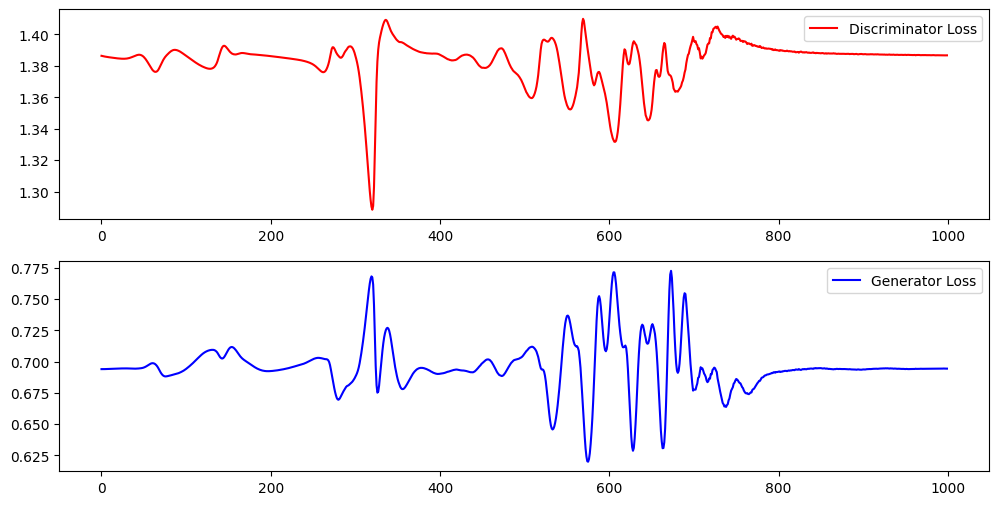

In [92]:
predicted_price, real_price, rmspe = train(X_train, y_train, yc_train, epochs, 
                                           generator, discriminator, g_optimizer, d_optimizer)

In [93]:
test_generator = tf.keras.models.load_model(f'./models_gan/default_stock/generator_V_{epochs-1}.h5')
# test_generator = tf.keras.models.load_model('./models_gan/improved_wgan_gp/best_generator.h5')

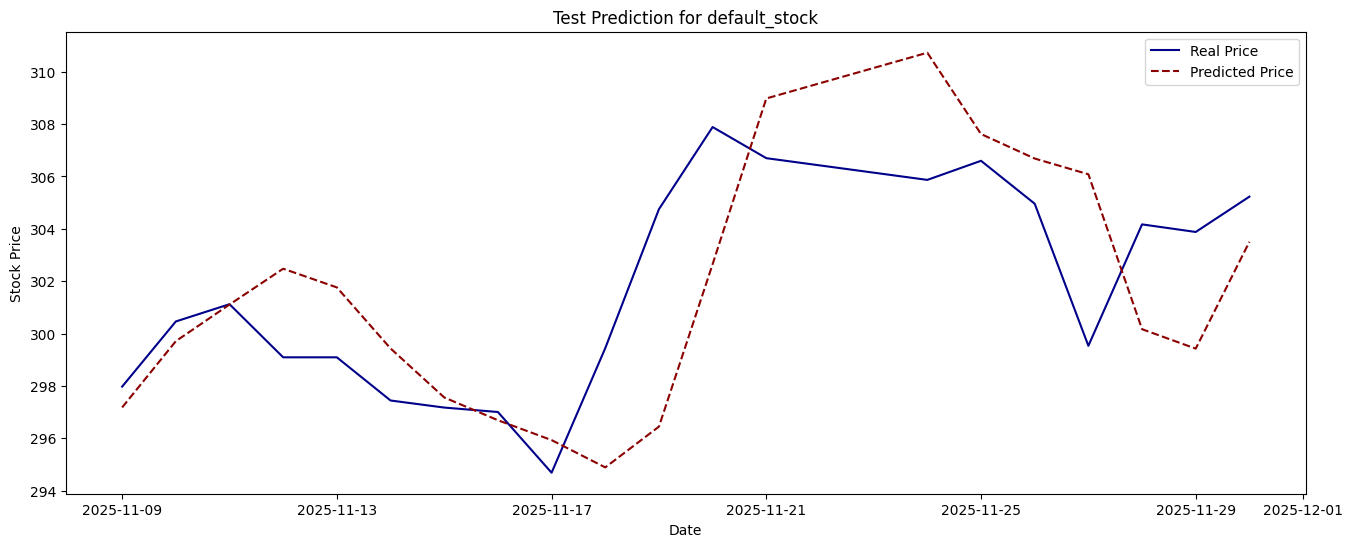

Test RMSE: 3.58835
Test MAE: 2.81475
Test MSE: 12.87628
Direction Accuracy: 0.6842 (68.42%)


In [94]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

## ПРЕДСКАЗАНИЕ N ДНЕЙ

In [31]:
import pandas as pd
import numpy as np

def compute_indicators(df):
    df = df.copy()

    df['MA7'] = df['close'].rolling(7).mean()
    df['MA20'] = df['close'].rolling(20).mean()
    df['20SD'] = df['close'].rolling(20).std()

    df['upper_band'] = df['MA20'] + 2 * df['20SD']
    df['lower_band'] = df['MA20'] - 2 * df['20SD']

    df['EMA'] = df['close'].ewm(span=20, adjust=False).mean()
    df['MACD'] = df['close'].ewm(span=12).mean() - df['close'].ewm(span=26).mean()

    df['logmomentum'] = np.log(df['close'] / df['close'].shift(1))

    return df

In [ ]:
def forecast_n_days(
    model,
    last_history_df,
    n_days,
    X_scaler,
    y_scaler,
    sentiment_score
):
    history = last_history_df.copy()
    preds = []

    for _ in range(n_days):
        window = history.tail(5)

        X_raw = window[[
            'open','close','high','low','value','volume',
            'sentiment_score','MA7','MA20','MACD','20SD',
            'upper_band','lower_band','EMA','logmomentum'
        ]].values

        X_scaled = X_scaler.transform(X_raw)
        X_scaled = X_scaled.reshape(1, 5, 15)

        y_scaled = model.predict(X_scaled, verbose=0)
        close_pred = y_scaler.inverse_transform(y_scaled)[0, 0]
        preds.append(close_pred)

        new_row = history.iloc[-1].copy()

        new_row['open'] = close_pred
        new_row['close'] = close_pred
        new_row['high'] = close_pred
        new_row['low'] = close_pred

        new_row['sentiment_score'] = sentiment_score
        new_row['volume'] = history['volume'].mean()
        new_row['value'] = history['value'].mean()

        history = pd.concat(
            [history, pd.DataFrame([new_row])],
            ignore_index=True
        )

        history = compute_indicators(history)

    return preds

In [34]:
import joblib

X_scaler = joblib.load("X_scaler.pkl")
y_scaler = joblib.load("y_scaler.pkl")
model = tf.keras.models.load_model("models_gan/default_stock/generator_V_499.h5")

In [59]:
preds = forecast_n_days(
    model,
    last_history_df=dataset.tail(30),
    n_days=5,
    X_scaler=X_scaler,
    y_scaler=y_scaler,
    sentiment_score=1
)

print(preds)

[np.float32(297.634), np.float32(282.64447), np.float32(282.646), np.float32(282.64703), np.float32(282.64767)]


In [ ]:
generator = tf.keras.models.load_model("models_gan/default_stock/generator_V_499.h5", compile=False)
generator.save("generator_model.keras")

In [ ]:
# базовый прогноз
base = forecast_n_days(model,
    last_history_df=dataset.tail(30),
    n_days=5,
    X_scaler=X_scaler,
    y_scaler=y_scaler, sentiment_score=0)

# экстремальный позитив
pos = forecast_n_days( model,
    last_history_df=dataset.tail(30),
    n_days=5,
    X_scaler=X_scaler,
    y_scaler=y_scaler,sentiment_score=+1)

# экстремальный негатив
neg = forecast_n_days( model,
    last_history_df=dataset.tail(30),
    n_days=5,
    X_scaler=X_scaler,
    y_scaler=y_scaler,sentiment_score=-1)

print("base:", base)
print("pos :", pos)
print("neg :", neg)

base: [np.float32(297.634), np.float32(282.6441), np.float32(282.64456), np.float32(282.64368), np.float32(282.64267)]
pos : [np.float32(297.634), np.float32(282.64447), np.float32(282.646), np.float32(282.64703), np.float32(282.64767)]
neg : [np.float32(297.634), np.float32(282.64377), np.float32(282.64334), np.float32(282.641), np.float32(282.6389)]


Результаты сценарного прогнозирования показали, что показатель тональности оказывает умеренное, но устойчивое влияние на прогнозируемую динамику цены. 

Эффект проявляется не в резких скачках, а в постепенном смещении траектории прогноза, что соответствует эмпирическим наблюдениям о влиянии общественных настроений на финансовые рынки».

Настроения пользователей корректируют прогноз, но не определяют его полностью.

День +2 → +5

Разница между сценариями:

День	pos	base	neg	Δ(pos−neg)
+2	282.64447	282.64410	282.64377	~0.0007
+3	282.64600	282.64456	282.64334	~0.0027
+4	282.64703	282.64368	282.64100	~0.0060
+5	282.64767	282.64267	282.63890	~0.0088

Эффект sentiment НАКАПЛИВАЕТСЯ
Негатив тянет вниз, позитив — вверх

In [64]:
dataset.head()

,open,close,high,low,value,volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
2025-02-03,280.21,279.55,280.35,278.00,8.477126e+09,30373760.0,0.054442,279.561429,279.3755,-0.444687,2.928295,285.232090,273.518910,279.991292,5.629598
2025-02-04,279.55,277.40,281.41,275.70,6.685825e+09,23986670.0,-0.072739,279.084286,279.5270,-0.568612,2.727171,284.981343,274.072657,278.263764,5.621849
2025-02-05,277.30,282.88,283.89,275.34,1.203512e+10,43070410.0,0.162981,280.177143,279.8210,0.152345,2.757191,285.335383,274.306617,281.341255,5.641481
2025-02-06,283.89,287.15,288.92,282.09,1.988558e+10,69363150.0,0.020372,281.434286,280.5885,0.139897,2.534360,285.657220,275.519780,285.213752,5.656516
2025-02-07,287.66,285.81,288.90,285.08,7.924869e+09,27626070.0,-0.078623,282.212857,280.9405,-0.531894,2.748355,286.437211,275.443789,285.611251,5.651822


In [68]:
def forecast_n_days(
    model,
    last_history_df,
    n_days,
    X_scaler,
    y_scaler,
    sentiment_score
):
    import tensorflow as tf

    print(f"Start forecast for {n_days} days")
    history = last_history_df.copy()
    preds = []

    for i in range(n_days):
        print(f"Day {i+1}")
        window = history.tail(5).copy()
        print("Window shape:", window.shape)

        # Обновляем sentiment
        window['sentiment_score'] = sentiment_score

        # Берём признаки
        X_df = window[FEATURE_COLS].copy()
        X_scaled = X_scaler.transform(X_df)
        X_scaled = X_scaled.astype(np.float32)  # <- важно для Mac ARM
        X_scaled = X_scaled.reshape(1, 5, 15)

        # TensorFlow predict
        X_tensor = tf.convert_to_tensor(X_scaled, dtype=tf.float32)

        try:
            y_scaled = model.predict(X_tensor, verbose=0, batch_size=1)
        except Exception as e:
            print("Error during predict:", e)
            return preds

        close_pred = y_scaler.inverse_transform(y_scaled.astype(np.float32))[0, 0]
        print("Predicted close:", close_pred)
        preds.append(float(close_pred))

        # Формируем "будущий" день
        new_row = history.iloc[-1].copy()
        new_row['open'] = close_pred
        new_row['close'] = close_pred
        new_row['high'] = close_pred
        new_row['low'] = close_pred
        new_row['sentiment_score'] = sentiment_score
        new_row['volume'] = history['volume'].mean()
        new_row['value'] = history['value'].mean()

        history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)
        history = compute_indicators(history)

    return preds

In [74]:
X_SCALER_PATH = "/Users/annapetrov/Downloads/study/диплом_мага/final_code/site_version2/models/X_scaler.pkl"
Y_SCALER_PATH = "/Users/annapetrov/Downloads/study/диплом_мага/final_code/site_version2/models/y_scaler.pkl"
X_scaler = joblib.load(X_SCALER_PATH)
y_scaler = joblib.load(Y_SCALER_PATH)
model = tf.keras.models.load_model("/Users/annapetrov/Downloads/study/диплом_мага/final_code/site_version2/models/generator_model.keras", compile=False)

In [76]:
DATA_PATH = "/Users/annapetrov/Downloads/study/диплом_мага/final_code/site_version2/data/stock_data.csv"
df = pd.read_csv(DATA_PATH, parse_dates=["date"])

FEATURE_COLS = [
    'open', 'close', 'high', 'low', 'value', 'volume',
    'sentiment_score', 'MA7', 'MA20', 'MACD',
    '20SD', 'upper_band', 'lower_band', 'EMA', 'logmomentum'
]

In [77]:
data = df.sort_values("date")

In [78]:
history = data.tail(30)

In [80]:
print("History tail:", history.tail(2))

History tail:           date    open   close    high     low         value     volume  \
268 2025-11-29  304.32  303.88  304.97  303.76  2.943098e+08   967797.0   
269 2025-11-30  303.86  305.23  305.43  303.60  6.036735e+08  1979918.0   

     sentiment_score     MA7     MA20      MACD      20SD  upper_band  \
268         0.002483  304.53  301.287 -2.644310  3.944126  309.175251   
269         0.004919  304.32  301.652 -2.412868  3.954875  309.561750   

     lower_band         EMA  logmomentum  
268  293.398749  303.680333     5.713337  
269  293.742250  304.713444     5.717784  


In [82]:
forecast_values = [float(x) for x in forecast_n_days(
                        model,
                        last_history_df=history,
                        n_days=5,
                        X_scaler=X_scaler,
                        y_scaler=y_scaler,
                        sentiment_score=0
                    )]

Start forecast for 5 days
Day 1
Window shape: (5, 16)
Predicted close: 300.07498
Day 2
Window shape: (5, 16)
Predicted close: 282.6445
Day 3
Window shape: (5, 16)
Predicted close: 282.6442
Day 4
Window shape: (5, 16)
Predicted close: 282.6438
Day 5
Window shape: (5, 16)
Predicted close: 282.64273


In [83]:
print("Forecast values:", forecast_values)

Forecast values: [300.0749816894531, 282.6445007324219, 282.6441955566406, 282.643798828125, 282.6427307128906]
